# Discrete time Quantum Walk on a Line

The basic setup of a quantum walk consists of a quantum walker represented by the position eigenstate $\ket{i}$ and an operation (usually called a coin operation) that is used by the quantum walker to make their choice of subsequent steps.We will be exploring discrete-time quantum walks in this notebook, where the position eigenstates $\ket{i}$ of the quantum walker are discrete states.

Let us study a simple example to understand how a quantum walk on a line works.

---

#### Hilbert Spaces

Let $H_W$ be the Hilbert space spanned by the positions of the quantum walker. For a line, this space can be spanned by the basis states ${\ket{i} : i \in \mathbb{Z}}$. For example, for a line with $N=16$ possible positions (or nodes), a $4$-qubit basis state given by ${\ket{0}, \ket{1}, \ket{2}, \ldots, \ket{15}}$ can be used for spanning the discrete position space of the walker.

Let $H_C$ be the Hilbert space spanned by the two basis states of a spin-$\frac{1}{2}$ particle, also called a coin in the context of quantum walk. We denote the two basis states as $\ket{\uparrow}$ (spin up) and $\ket{\downarrow}$ (spin down). Because of this choice of the coin, the quantum walker can move to two possible positions with certain probabilities during a step of the quantum walk. In more complicated cases (like $2D$ quantum walks) where there can be more than two possible choices, we can choose basis states of a spin-$s$ particle, which allows for $2s+1$ single-step transitions.

Thus, the full Hilbert space of a quantum walk system is given as $H_W \otimes H_C$.

---

#### Quantum Walk Operation

For simplicity, let's work with a Hadamard coin that allows for equal likelihood for the transition of a quantum walker to the right and to the left. Consider the conditional translation of the quantum walker based on the coin state. That is, if the coin is in the state $\ket{\uparrow}$ the position of the walker shifts one step towards the right and if the coin is in the state $\ket{\downarrow}$ the position of the walker shifts one step towards the left. The below conditional shift operator achieves this:

$$ S= \ket{\uparrow}\bra{\uparrow} \otimes \sum_i \ket{i+1}\bra{i} + \ket{\downarrow}\bra{\downarrow} \otimes \sum_i \ket{i-1}\bra{i}$$

Example, $$ S\ket{\uparrow} \otimes \ket{2} = \ket{\uparrow} \otimes \ket{3}$$ as expected because the coin state $\ket{\uparrow}$ dictates the walker to move one step towards the right, which is the position $\ket{3}$. 

A quantum random walk has two processes occuring in every step. First, a coin is flipped and then the position state of the walker changes based on the coin flip outcome. This operation is denoted as,
$$ U= S(C\otimes I) $$

where $C$ (here $C=H$, the hadamard operation) is the coin flip operation and $S$ is defined above. 

For example, let the initial state be $\ket{\uparrow}\otimes\ket{0}$, which means the walker is in the position state $\ket{0}$ and the coin is in the state $\ket{\uparrow}$. 

Now the coin flip operation followed by action of $S$ yields the following state,

$$\frac{1}{\sqrt{2}}(\ket{\uparrow}\otimes\ket{1} + \ket{\downarrow}\otimes\ket{-1})$$ 

as expected the walker shifts to left or right of $\ket{0}$ depending on the coin state. 

If the coin state is measured and the process is continued we obtain a classical walk. Interesting quantum effects can be seen if we don't measure the states and continue the walk by acting $U$ repeatedly. After several applications of $U$ (several steps of the quantum walk), we will obtain a bimodal distribution of the position of the walker, which will be peaked on the extreme right with a nearly uniform distribution in the middle and a small peak on the extreme left. If the initial state be $\ket{\downarrow}\otimes\ket{0}$,the bigger peak is on the left. This is clearly different from a classical random walk, which has a peak at the middle (position state $\ket{0}$)
___

##### More interesting distributions can be observed by varying the coin operation. For symmetric peaks on either sides we can chose $C= \frac{1}{\sqrt{2}}(\mathbb{I} + i \sigma_x)$
___

In [56]:
# defining the coin flip operator, here a Hadamard coin is chosen

@qfunc
def quantum_coin_flip(coin: QBit):
    H(coin)


# defining the function that incresease the position of the walker by one

@qfunc
def quantum_step_right(x: QArray):

    within_apply(
        lambda: qft(x),
        lambda: repeat(x.len, lambda i: PHASE(2 * pi * 2 ** (i) / (2**x.len), x[i])),
    )

# quantum walk operation, includes flipping a coin and controlled change in position of walker based on coin state, repeating the walk for steps= time

@qfunc
def discrete_quantum_walk_line(
    time: CInt,  # total time
    x: QArray[QBit],  # position
):
    coin = QNum("coin")
    allocate(1, coin)
    power(
        time,
        lambda: (
            quantum_coin_flip(coin),
            control(coin == 0, lambda: quantum_step_right(x)),
            control(coin == 1, lambda: invert(lambda: quantum_step_right(x))),
        ),
    )

line_nodes= 2**4   # a line with 16 nodes
t = 50

@qfunc
def main(t: CInt, x: Output[QNum]):

    allocate_num(floor(log(line_nodes, 2)), True, 0, x)
    inplace_prepare_int(7,x)   # walk starting at position 64
    discrete_quantum_walk_line(t, x)



qmod = create_model(main)
execution_preferences=ExecutionPreferences(num_shots=1000)
qmod= set_execution_preferences(qmod, execution_preferences)
qprog = synthesize(qmod)
show(qprog)


Opening: https://platform.classiq.io/circuit/5a020681-ea5a-4164-af27-86c759d56cdc?version=0.43.2


The synthesized circuit for the above program isn't being executed as of now. Discussing this on Slack. 

## An implementation of more general quantum walks:

Its easy to see that the approach discussed above for a quantum walk on a line cannot be generalized to quantum walks on any graphs. Let's illustrate this further. 

Consider a quantum random walk on a triangle where transitions are possible from every vertex to every other vertex. 


<img src="image.png" alt="image" style="width:300px;"/>

Now, let's start with the coin state $\ket{\uparrow}$ which on a flip (Hadamard operation) gives $\ket{c}= \frac{\ket{\uparrow} + \ket{\downarrow}}{\sqrt{2}} $

If the initial state of the quantum walker is $\ket{2}$, then a physically possible shift operation could be, $$ S(\ket{c} \otimes \ket{2})= \frac{\ket{\uparrow}}{\sqrt{2}} \otimes \ket{0} +  \frac{\ket{\downarrow}}{\sqrt{2}} \otimes \ket{1}$$

Now, consider the initial state of the quantum walker is $\ket{1}$ (orthogonal to $\ket{2}$), then a physically possible shift could be $$ S(\ket{c} \otimes \ket{1})= \frac{\ket{\uparrow}}{\sqrt{2}} \otimes \ket{0} +  \frac{\ket{\downarrow}}{\sqrt{2}} \otimes \ket{2}$$

This leads to the following conclusion: Although the initial states were orthogonal to each other, the application of a physically possible $S$ resulted in the final states that are not orthogonal to each other, this is because vertices $\ket{1}$  and $\ket{2}$ have an edge (representing transition) to a common vertex $\ket{0}$. Thus such an operation $S$ cannot be unitary.

---




So for general quantum walks we chose the $\ket{j,k}$ basis where $\ket{j,k}$ represents a transition of a walker from $\ket{j} -> \ket{k}$ that is $(j,k)$ is an edge in the graph. With this we can always have a unitary transformation,  $U \ket{j,k} = \ket{l,m}$ where,  $\ket{l,m}$ represents the transition from $\ket{l} -> \ket{m}$


Each step of the walk consists of two operations. First, we apply a unitary transformation that operates on the second register conditional on the first register. This transformation is the “coin flip,” operation as it modifies the next destination of the walker. A common choice is the **Grover diffusion operator** over the neighbors of $\ket{j}$,

$$ C := \sum_j |j\rangle\langle j| \otimes \left(2|\partial j\rangle\langle \partial j| - I\right) $$

where $|\partial j \rangle := \frac{1}{\sqrt{\deg(j)}} \sum_{k:(j,k) \in E} |k\rangle$


Next, the walker is moved to the vertex indicated in the second register. Since the process must be unitary, the only way to do this is to swap the two registers using the operator,

$$S := \sum_{(j,k) \in E} |j, k\rangle\langle k, j|$$


Thus we have $U= S.C$, for example if the initial state is $\ket{0,1}$ a simple calculation would yield the following,

$$U\ket{0,1}= S.C \ket{0,1}= S\ket{0,1}=\ket{1,0}$$

In principle, we can use this construction to define a discrete-time quantum walk on any graph

### Implementation of quantum walk on a line with 16 nodes

<img src="image2.png" alt="image2" style="width:600px;"/>

In [88]:
import classiq
from classiq import *
from classiq.execution import ExecutionDetails, ExecutionPreferences, ClassiqBackendPreferences
import matplotlib.pyplot as plt
from classiq.execution import ExecutionPreferences
from classiq.qmod.symbolic import floor, log, pi, ceiling

size = 4  # qubits needed for storing the 16 positions


---
#### Preparing the Grover diffusion operator and the Coin operator

The Grover diffusion operator, $D= \left(2|\partial j\rangle\langle \partial j| - I\right) $, includes a step known as the **zero diffuser**. This is typically represented by the operator $2\ket{0}^{\otimes n}\bra{0}^{\otimes n} - I$, where $I$ is the identity matrix.


$$\ket{\partial j} = U \ket{0}^{\otimes n}= \frac{1}{\sqrt{\deg(j)}} \sum_{k:(j,k) \in E} |k\rangle$$

In the context of the zero diffuser, this operation reflects the amplitude of the $\ket{0}^{\otimes n}$ state while inverting the amplitude of all other states.

In [89]:
## Preparing the zero diffuser 

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):  
  aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):   
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),  
              action=lambda: diffuzer_oracle)

The coin operator $ C := \sum_j |j\rangle\langle j| \otimes \left(2|\partial j\rangle\langle \partial j| - I\right) $ is basically the application of Grover's Diffusion operator on the second set of registers, controlled by the first set of registers.

In [90]:
## Preparing the coin operator C

def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):

    # state preparation (U matrix), we assume here that at every state there is equal probability of going left/right and state 0 and state 15 are absorbing states 
    prob = [0 for j in range(2**size)]   
    if i==int(2**size - 1):
      prob[i-1]=1  #this condition is to make sure that if the walker reaches the node 15, he goes to 14 in the next step with probability 1
    elif i== 0:
      prob[i+1]=1  ##this condition is to make sure that if the walker reaches the node 0, he goes to 11 in the next step with probability 1
    else: 
      prob[i+1]=0.5  #if the walker is at any other node, there's equal chance of going right/left with equal probability 
      prob[i-1]=0.5
    
    # this part prepares the coin operator

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

In [91]:
## Perparing the S operator that swaps vertices connected by an edge 

@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

#### Implementing one step of a quantum walk

Basically application of the operator $C.S$ on an initial state $\ket{j,k}$

In [92]:
## Quantum walk implementation

@qfunc 
def main(vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  adjacent_vertices= QNum('av')
  allocate(size,adjacent_vertices)  
  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)


We use the nvidia_state_vector_simulator as the above program requires $25$ (and sometimes $26$) qubits without constraints. Execution and processing results the results can be done as follows.

max_width=25 max_depth=None max_gate_count=defaultdict(<class 'int'>, {}) optimization_parameter=<OptimizationParameter.NO_OPTIMIZATION: 'no_opt'>
Time  preprocessing=1.1163397699128836 solving=3.889027054188773 conversion_to_circuit=0.20653193490579724 postprocessing=2.8540338359307498
Width 25
***********
Opening: https://platform.classiq.io/circuit/9039ca97-c878-488f-8994-c974adc13de8?version=0.43.2


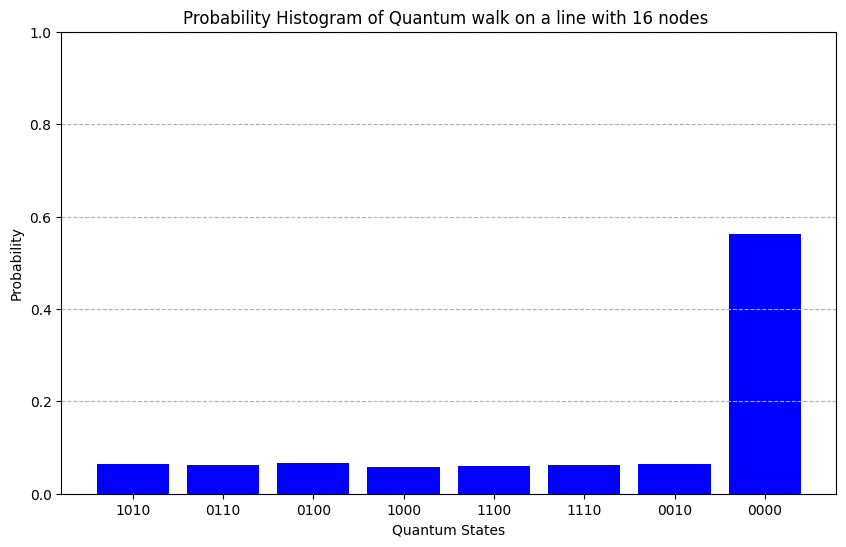

In [93]:
def run(constraints):
    qmod = create_model(main)
    if constraints is not None:
        qmod = set_constraints(qmod, constraints)
    # backend_preferences = ClassiqBackendPreferences(backend_name="nvidia_state_vector_simulator")
    # execution_preferences=ExecutionPreferences(num_shots=1000, backend_preferences=backend_preferences)
    # qmod= set_execution_preferences(qmod, execution_preferences)
    qprog = synthesize(qmod)
    print(constraints)
    print("Time ", QuantumProgram.parse_raw(qprog).synthesis_duration)
    print("Width", QuantumProgram.parse_raw(qprog).data.width)
    print("***********")
    show(qprog)
    if QuantumProgram.parse_raw(qprog).data.width<= 30:
        results = execute(qprog).result()
        dict_counts= results[0].value.counts

        # Total number of results
        total_counts = sum(dict_counts.values())

        # Calculate probabilities
        probabilities = {state: count / total_counts for state, count in dict_counts.items()}

        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.bar(probabilities.keys(), probabilities.values(), color='blue')
        plt.xlabel('Quantum States')
        plt.ylabel('Probability')
        plt.title('Probability Histogram of Quantum walk on a line with 16 nodes ')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--')

        # Show the plot
        plt.show()

 
for c in [
    Constraints(
        max_width=25
    )
]:
    run(c)
